In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx

import os
import imageio
from io import BytesIO

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from experiments import (plot_dim1, plot_dimN, plot_correlation_error, get_metrics, plot_node_emb_1D_perclass, scatter_node_emb,  plot_graph_emb_1D, plot_data_degree_sequence,
                         init_GCN, init, init_model_dataset, train_take_embedding_alreadyinit, train_take_embedding, experiment_node_embedding, elaborate_embeddings,
                         run_with_weights)
from config_valid import Config, TrainingMode
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from many_runs import make_config_cm, config2df

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats


from plt_parameters import init_params
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

# Classification CM power law, init weights

In [260]:
config_file = "configurations/classification_cm.yml"
dataset, model, trainer, config_c = init(config_file)

Create dataset
Generating dataset...
Dataset generated
Initialize model


##### Plot del grafo

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1)
G1 = dataset.dataset_list[550]
plot_grafo(axs[0], G1, iterations=1000)   
G2 = dataset.dataset_list[70]
plot_grafo(axs[1], G2, iterations=1000)   

#fig.savefig("2grafi.png", dpi=72)

In [261]:
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)

100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 92.32it/s]

Tempo impiegato: 6.555656433105469


In [240]:
#view_parameters(model)

In [262]:
#print("Parametri attuali")
#view_parameters(model)
print("Cambio i parametri...")
new_par = new_parameters(model, method=Inits.xavier_uniform)#, method='esn')
#print(new_par)
modify_parameters(model, new_par)
#print("Parametri nuovi")
#view_parameters(model)

Cambio i parametri...


In [263]:
#model = init_GCN(config_c, verbose=False)
trainer.reinit_conf_file(config_file)
trainer.reinit_model(model)

In [264]:
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer, model)#, config_c) # reinserisco il modello aggiornato #
emb_perclass0, emb_perclass1 = elaborate_embeddings(config_c, graph_embeddings_array, model, node_embeddings_array, node_embeddings_array_id, test_loss_list, trainer)

Before training Test loss: 0.015292804439862568
Run training for 50 epochs
Epoch: 49	Test loss: 0.015479090147548252 		 FINE TRAINING


## Plot training data degree sequence histogram

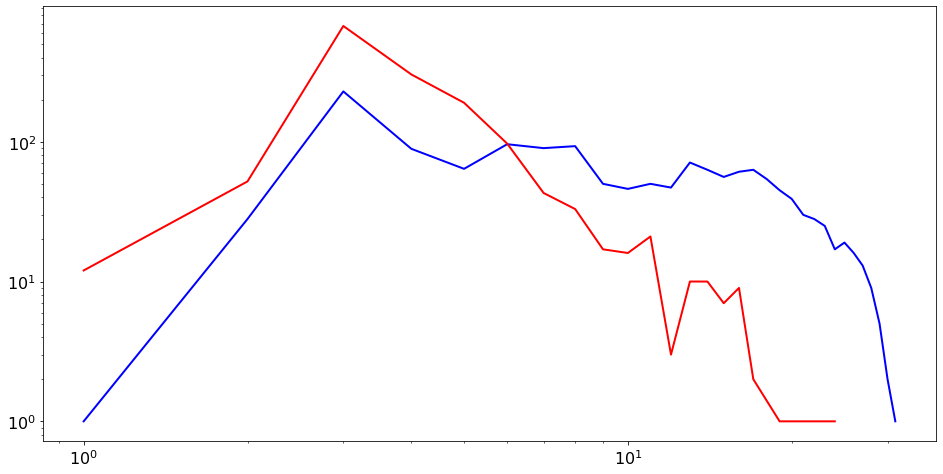

In [6]:
all_nodelabel = [e.node_label for e in emb_perclass0]
counts = np.unique(all_nodelabel, return_counts=True)
plt.loglog(*counts, c='blue')#, alpha=0.1)
all_nodelabel = [e.node_label for e in emb_perclass1]
counts = np.unique(all_nodelabel, return_counts=True)
plt.loglog(*counts, c='red')#, alpha=0.1)

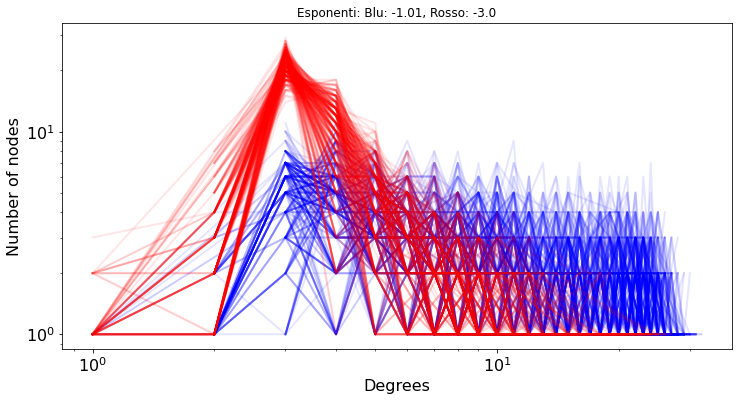

In [6]:
plot_data_degree_sequence(config_c, emb_perclass0, emb_perclass1)

## Plot embedding ordered degrees and training data ordered degrees

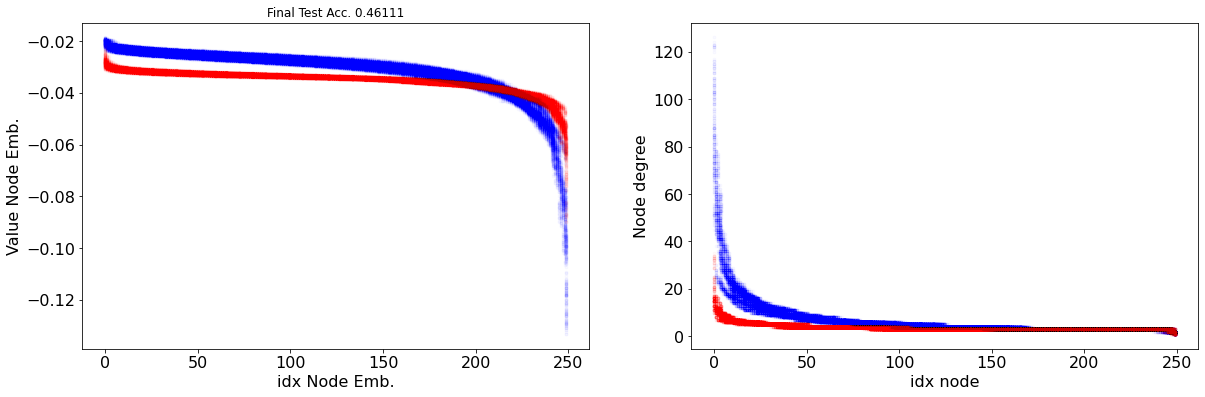

In [265]:
plot_node_emb_1D_perclass(emb_perclass0, emb_perclass1, trainer.last_accuracy)

## Scatter del node embedding vs degree sequence

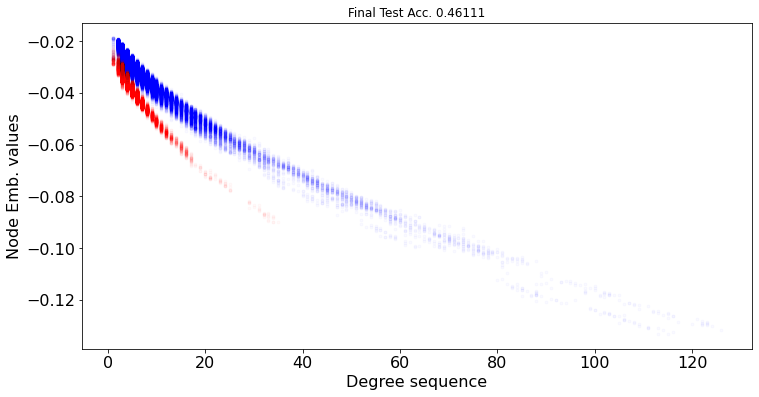

In [266]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

### Graph embedding histogram

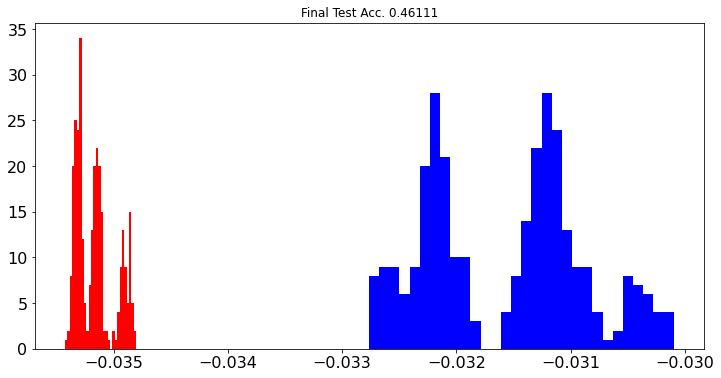

In [267]:
plot_graph_emb_1D(emb_perclass0, emb_perclass1, trainer.last_accuracy)

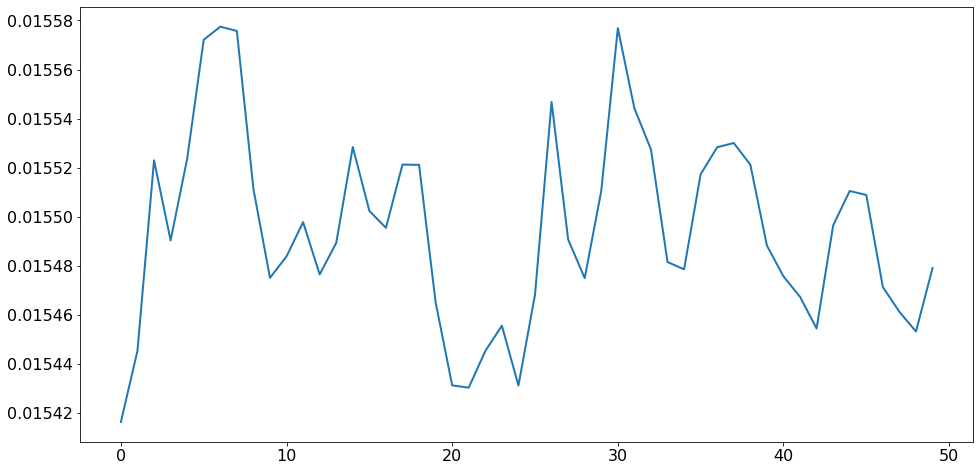

In [268]:
plt.plot(trainer.test_loss_list)

In [259]:
t = trainer
c = config_c
make_gif(Inits.xavier_uniform)

scatter_xavier_uniform_exp[-2.5, -4.5]_nodi[250, 250]_grafi600_percent0.7_layers[1, 16, 16, 1]_finaldenseTrue.gif


/tmp/ipykernel_904238/1169589655.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in pictures]


# Verifico loss 

In [221]:
model.eval()
all_data_loader = DataLoader(trainer.dataset.dataset_pyg, batch_size=trainer.dataset.bs, shuffle=False)
graph_emb = []
graph_emb_gpu = []
targets = []
targets_gpu = []
running_loss = 0
#for data in all_data_loader:
for data in trainer.dataset.test_loader:
    out = model(data.x, data.edge_index, data.batch, graph_embedding=True)
    target = trainer.correct_shape(data.y)
    loss = trainer.criterion(out, target)
    graph_emb.extend(out.cpu().detach().numpy())
    targets.extend(target.cpu().detach().numpy())
    graph_emb_gpu.extend(out)
    targets_gpu.extend(target)
    running_loss += loss.item()

print(f"loss: {running_loss / trainer.dataset.test_len}")
graph_emb = np.array(graph_emb).flatten()
targets = np.array(targets).flatten()
print(len(graph_emb), len(targets), trainer.dataset.test_len)

loss: 0.015333688259124756
180 180 180


In [222]:
graph_emb_gpu = torch.reshape(torch.Tensor(graph_emb_gpu), (-1,1))
targets_gpu = torch.reshape(torch.Tensor(targets_gpu), (-1,1))
total_loss = trainer.criterion(graph_emb_gpu, targets_gpu)
print(f"loss: {total_loss/ trainer.dataset.test_len}")
print(len(graph_emb_gpu), len(targets_gpu), trainer.dataset.test_len)

loss: 0.003833652939647436
180 180 180


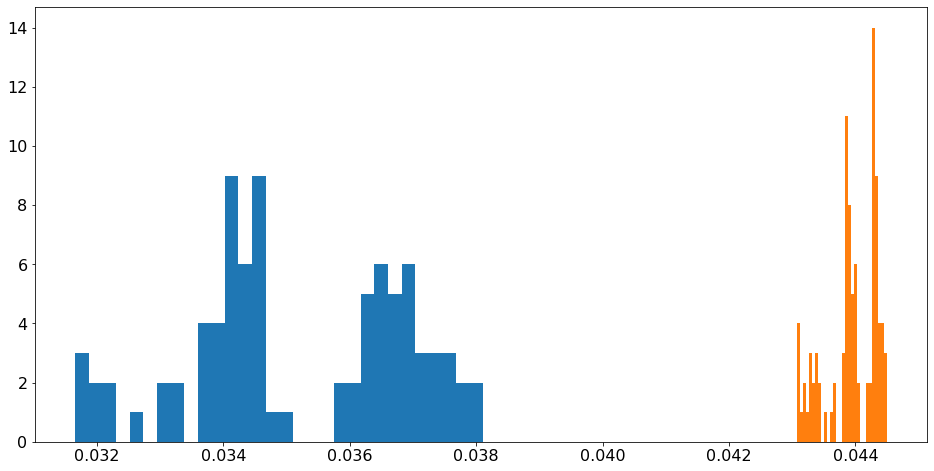

In [223]:
emb_targ = list(zip(graph_emb, targets))
emb_targ_0 = [e[0] for e in emb_targ if e[1] == 0]
emb_targ_1 = [e[0] for e in emb_targ if e[1] == 1]

plt.hist(emb_targ_0, bins=30);
plt.hist(emb_targ_1, bins=30);

### verifica manuale

In [225]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

BinaryCrossEntropy(targets, sigmoid(graph_emb)) / trainer.dataset.test_len


0.0038336515426635742

### shuffle target

In [233]:
import random
x = list(enumerate(targets_gpu))
random.shuffle(x)
indices, target_shuffled = zip(*x)
target_shuffled = torch.reshape(torch.Tensor(target_shuffled), (-1,1)).to(device)

trainer.criterion(graph_emb_gpu.to(device), target_shuffled) / trainer.dataset.test_len

tensor(0.0038, device='cuda:0')

In [180]:
trainer.criterion

BCEWithLogitsLoss()

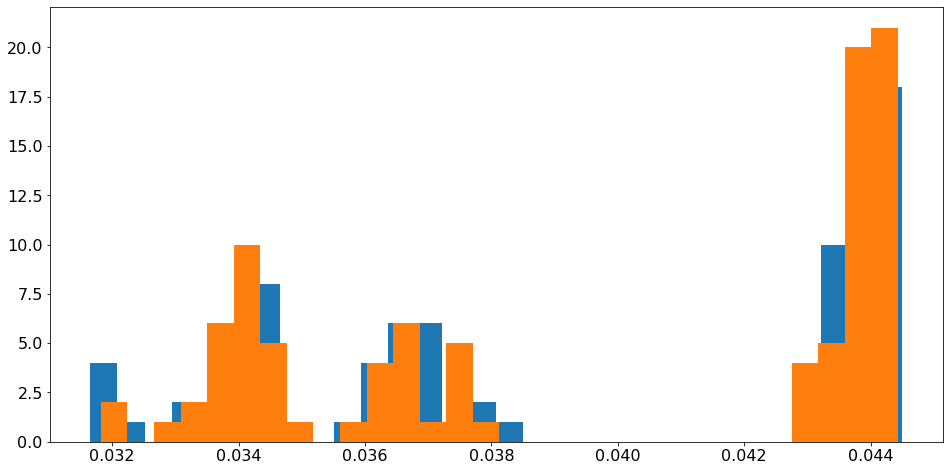

In [234]:
emb_targ_s = list(zip(graph_emb, target_shuffled))
emb_targ_s_0 = [e[0] for e in emb_targ_s if e[1] == 0]
emb_targ_s_1 = [e[0] for e in emb_targ_s if e[1] == 1]

plt.hist(emb_targ_s_0, bins=30);
plt.hist(emb_targ_s_1, bins=30);

In [237]:
BinaryCrossEntropy(target_shuffled.to('cpu').numpy().flatten(), sigmoid(graph_emb)) / trainer.dataset.test_len

0.0038459625509050157

# Codice

In [7]:
def save_many_images_embedding(trainer, config_c, node_embeddings_array_id=[0]):
    for i in range(trainer.epochs):
        graph_embeddings_array = trainer.graph_embedding_per_epoch[i]
        node_embeddings_array = trainer.node_embedding_per_epoch[i]
        emb_perclass0, emb_perclass1 = elaborate_embeddings(config_c, graph_embeddings_array, model, node_embeddings_array, node_embeddings_array_id, trainer.test_loss_list, trainer)
        scatter_node_emb(emb_perclass0, emb_perclass1, trainer.accuracy_list[i], f"scatter_epoch{i}", show=False, close=True)
        #plot_graph_emb_1D(emb_perclass0, emb_perclass1, trainer.last_accuracy)

def mylambda(i):
    graph_embeddings_array = t.graph_embedding_per_epoch[i]
    node_embeddings_array = t.node_embedding_per_epoch[i]
    emb_perclass0, emb_perclass1 = elaborate_embeddings(c, graph_embeddings_array, model, node_embeddings_array, [0], t.test_loss_list, t)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    scatter_node_emb(emb_perclass0, emb_perclass1, t.accuracy_list[i], ax=axes[0][0], show=False)
    plot_graph_emb_1D(emb_perclass0, emb_perclass1, t.accuracy_list[i], ax=axes[0][1], show=False)
    axes[1][0].plot(t.test_loss_list)
    axes[1][0].plot(i, t.test_loss_list[i], 'ro')
    axes[1][1].plot(t.accuracy_list)
    axes[1][1].plot(i, t.accuracy_list[i], 'ro')
    fig.suptitle(f"Esponenti power law{c.conf['graph_dataset']['list_exponents']}")
    #plt.savefig(f"scatter_epoch{i}")
    bio = BytesIO()
    fig.savefig(bio, format="png")
    plt.close()
    return bio
    
    
        
def parallel_save_many_images_embedding(lista):
    with Pool(processes=30) as pool:
        bios = pool.map(mylambda, lista)
    return bios

def make_gif(metodo_init):
    lista = range(0,t.epochs)
    pictures = parallel_save_many_images_embedding(lista)
    
    numnodi = c.conf['graph_dataset']['Num_nodes']
    numgrafi = c.conf['graph_dataset']['Num_grafi_per_tipo']*2
    exps = c.conf['graph_dataset']['list_exponents']
    percentuale_train = c.conf['training']['percentage_train']
    layers  = c.conf['model']['GCNneurons_per_layer']
    denso = c.conf['model']['last_layer_dense']
    nomefile = f"scatter_{metodo_init}_exp{exps}_nodi{numnodi}_grafi{numgrafi}_percent{percentuale_train}_layers{layers}_finaldense{denso}.gif"
    print(nomefile)
    #files = [f"scatter_epoch{i}.png" for i in lista]
    #ims = [imageio.imread(f) for f in files] 
    ims = [imageio.imread(f) for f in pictures]
    imageio.mimwrite(nomefile, ims, duration=0.045)
    
    #for f in files:
    #    os.remove(f)
        
    return

def plot_4(emb_class01, trainer, close=False):
    for i, (emb_perclass0, emb_perclass1) in enumerate(emb_class01):
        c = configs[i]
        #c = config_c
        #c.conf['last_accuracy'] = 0.99
        #plot_data_degree_sequence(config_c, emb_perclass0, emb_perclass1)
        #plot_node_emb_1D_perclass(emb_perclass0, emb_perclass1, c.conf['last_accuracy'])
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        scatter_node_emb(emb_perclass0, emb_perclass1, c.conf['last_accuracy'], ax=axes[0][0], show=False)
        plot_graph_emb_1D(emb_perclass0, emb_perclass1, c.conf['last_accuracy'], ax=axes[0][1], show=False)
        axes[1][0].plot(trainer.test_loss_list)
        axes[1][0].plot(10, trainer.test_loss_list[10], 'ro')
        axes[1][1].plot(trainer.accuracy_list)
        fig.suptitle(f"Esponenti power law{c.conf['graph_dataset']['list_exponents']}")
        #plt.show()
        if close:
            plt.close()

In [ ]:
plot_4(emb_class01, trainer)

# Many run configurations, same weights

In [4]:
config_file = "configurations/classification_cm.yml"
#model, trainer = init_model_dataset(config_file, parallel=False, verbose=False)

##### provo che n run con stessi parametri e stesso dataset vengano uguali

In [6]:
parameters = new_parameters(model, method=Inits.xavier_uniform)
emb_class01 = []
loss_lists = []
last_accura = []

config_c = Config(config_file)
for i in range(3):
    print(f'Run {i}')
    emb_perclass0, emb_perclass1 = run_with_weights(config_c, trainer, parameters)
    emb_class01.append((emb_perclass0, emb_perclass1))
    loss_lists.append(trainer.test_loss_list)
    last_accura.append(trainer.last_accuracy)

Run 0
Before training Test loss: 0.01540351774957445
Run training for 250 epochs
Epoch: 249	Test loss: 0.0002599409315735102 		 FINE TRAINING
Run 1
Before training Test loss: 0.01540351774957445
Run training for 250 epochs
Epoch: 249	Test loss: 0.0027105781560142835 		 FINE TRAINING
Run 2
Before training Test loss: 0.01540351774957445
Run training for 250 epochs
Epoch: 249	Test loss: 0.0009369288597048985 		 FINE TRAINING


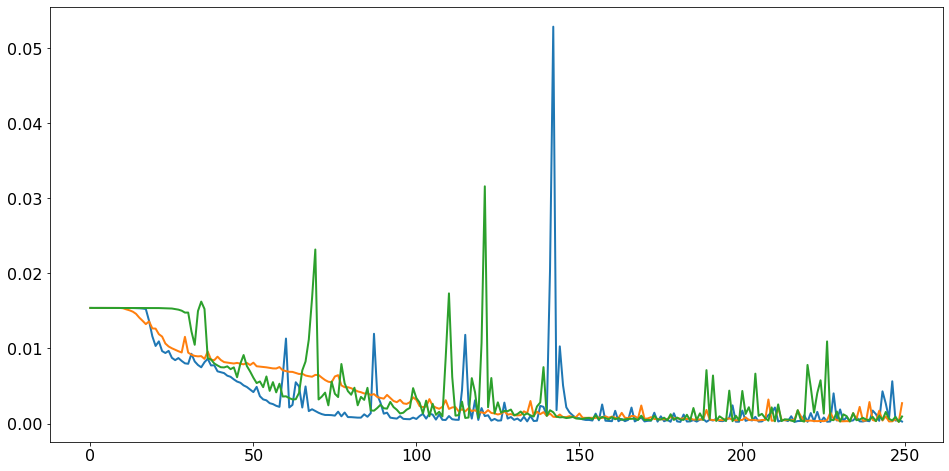

In [12]:
plt.plot(np.array(loss_lists).T)

### Define trials

In [94]:
#Num_nodes = [[i, i] for ii range(50, 300, 100)]
#Num_grafi_per_tipo: [i for i in range(50, 300, 100)]
list_exponents = [[-2.5, -3.5], [-2.5, -4.5]]

#trials = {}
#trials['list_exponents'] = list_exponents



In [23]:
config_c = Config(config_file)
configs = make_config_cm(config_c.conf, trials)

In [25]:
parameters = new_parameters(model, method=Inits.xavier_uniform)
emb_class01 = []
trainers = []

#graph_embeddings_array = t.graph_embedding_per_epoch[i]
#node_embeddings_array = t.node_embedding_per_epoch[i]
#emb_perclass0, emb_perclass1 = elaborate_embeddings(c, graph_embeddings_array, model, node_embeddings_array, [0], t.test_loss_list, t)
#scatter_node_emb(emb_perclass0, emb_perclass1, t.accuracy_list[i], f"scatter_epoch{i}", show=False, close=True)

for i, c in enumerate(configs):
    print(f'Run {i}/{len(configs)}')
    _, trainer = init_model_dataset(config_file)
    emb_perclass0, emb_perclass1 = run_with_weights(c, trainer, parameters) # il model viene ri inizializzato
    emb_class01.append((emb_perclass0, emb_perclass1))
    c.conf['test_loss'] = trainer.test_loss_list
    c.conf['last_accuracy'] = trainer.last_accuracy
    trainers.append(trainer)
    
    #c[f'run_num'] = j

Run 0/2
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 367.07it/s]


Tempo impiegato: 1.6753270626068115
Before training Test loss: 0.01540016598171658
Run training for 250 epochs
Epoch: 249	Test loss: 0.001615173773219188 		 FINE TRAINING
Run 1/2
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 301.95it/s]


Tempo impiegato: 2.0430192947387695
Before training Test loss: 0.015398945742183262
Run training for 250 epochs
Epoch: 249	Test loss: 0.00022920431478673384 		 FINE TRAINING


### Save gif

In [81]:
for i, t in enumerate(trainers):
    c = configs[i]
    make_gif()

/tmp/ipykernel_264456/541222714.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in pictures]


# Vario la percentuale dello split train test set per vedere l'accuracy

In [6]:
percentage_train = [0.6, 0.2]
#mode = ['mode1', 'mode2']
#Num_nodes = [[i, i] for i in range(50, 301, 250)]
#Num_grafi_per_tipo = [i for i in range(50, 301, 250)]
list_exponents = [[-2.5, -3.5], [-2.5, -4.5]]
denso = [False, True]    
#trials = list(itertools.product(percentage_train, mode, Num_nodes, Num_grafi_per_tipo, list_exponents))
trials = list(itertools.product(percentage_train, list_exponents, denso))

In [10]:
trials

[(0.6, [-2.5, -3.5], False),
 (0.6, [-2.5, -3.5], True),
 (0.6, [-2.5, -4.5], False),
 (0.6, [-2.5, -4.5], True),
 (0.2, [-2.5, -3.5], False),
 (0.2, [-2.5, -3.5], True),
 (0.2, [-2.5, -4.5], False),
 (0.2, [-2.5, -4.5], True)]

In [8]:
import copy
def make_config(config, trials):
    configs = []
    # for lr, layer, num_nodes in trials:
    for percentage_train in trials:
        #config['graph_dataset']['list_exponents'] = list_exponents
        config['training']['percentage_train'] = percentage_train
        copia = copy.deepcopy(config)
        confclass = Config.fromdict(copia)
        configs.append(confclass)
    return configs

config_c = Config(config_file)
configs = make_config(config_c.conf, trials)

dataset, model, trainer, config_c = init(config_file)

metodo=Inits.xavier_uniform
parameters = new_parameters(model, method=metodo)
#emb_class01 = []
#trainers = []

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [9]:
for i, c in enumerate(configs):
    print(f'Run {i+1}/{len(configs)}')
    try:
        _, t = init_model_dataset(config_file)
        emb_perclass0, emb_perclass1 = run_with_weights(c, t, parameters)
        #emb_class01.append((emb_perclass0, emb_perclass1))
        c.conf['test_loss'] = t.test_loss_list
        c.conf['last_accuracy'] = t.last_accuracy
        #trainers.append(trainer)
        make_gif(metodo)
    except Exception as e: 
        print(repr(e))

Run 1/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 266.67it/s]


Tempo impiegato: 2.301841974258423
Before training Test loss: 0.01540339986483256
Run training for 250 epochs
Epoch: 249	Test loss: 5.863495171070099e-05 		 FINE TRAINING


/tmp/ipykernel_743573/1004375323.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in pictures]


Run 2/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 252.97it/s]


Tempo impiegato: 2.4172604084014893
Before training Test loss: 0.015403274363941616
Run training for 250 epochs
Epoch: 249	Test loss: 0.0001182410814281967 		 FINE TRAINING
Run 3/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 223.62it/s]


Tempo impiegato: 2.727548122406006
Before training Test loss: 0.015403295225567288
Run training for 250 epochs
Epoch: 249	Test loss: 5.936222150921821e-05 		 FINE TRAINING
Run 4/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 202.96it/s]


Tempo impiegato: 3.0207369327545166
Before training Test loss: 0.015402771366967095
Run training for 250 epochs
Epoch: 249	Test loss: 2.5668661045427953e-05 		 FINE TRAINING
Run 5/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 199.31it/s]


Tempo impiegato: 3.124682664871216
Before training Test loss: 0.01540369623237186
Run training for 250 epochs
Epoch: 249	Test loss: 0.00022047702740463947 		 FINE TRAINING
Run 6/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 229.85it/s]


Tempo impiegato: 2.6663970947265625
Before training Test loss: 0.01540232366985745
Run training for 250 epochs
Epoch: 249	Test loss: 4.887313181017008e-05 		 FINE TRAINING
Run 7/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 189.86it/s]


Tempo impiegato: 3.220322370529175
Before training Test loss: 0.01540289024511973
Run training for 250 epochs
Epoch: 249	Test loss: 7.73899787519541e-05 		 FINE TRAINING
Run 8/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 189.15it/s]


Tempo impiegato: 3.2282421588897705
Before training Test loss: 0.01540466116534339
Run training for 250 epochs
Epoch: 249	Test loss: 7.319507939327095e-05 		 FINE TRAINING


In [ ]:
for i, t in enumerate(trainers):
    try:
        c = configs[i]
        make_gif_animata(metodo)
    except Exception as e: 
        print(repr(e)) 

# TODO: tenere fissa l'inizializzazione al variare del numero di nodi, di grafi, e degli esponenti
# regressione con una distribuzione discreta e continua sugli esponenti
# aggiungere un layer denso con un neurone
# plottare con limiti fissi per vedere meglio cosa fa durante il training
# continuare con il refactoring sul notebook proj overview, riapplicando tutto anche ai grafi regolari e a ER